<a href="https://colab.research.google.com/github/Harryte/Empty-Shelve-Detection-MS-Thesis/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Declaration

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2
import csv,os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_doh
from keras.models import model_from_json  #keras v 2.1.5  default for Tensorflow 2.2.0

## Image file path declaration

In [4]:
shelves_images_path = "/drive/MyDrive/MS/WebMarket/"
preprocessed_image_path = "/drive/MyDrive/MS/WebMarket/preprocessed/"
CV2_Segmentation_path = "/drive/MyDrive/MS/WebMarket/segmentation/"
shelves_coordinates_file="/drive/MyDrive/MS/WebMarket/db1_data.csv"

In [5]:
image_path = os.listdir(os.getcwd() + shelves_images_path)
image_path

['db103.jpg',
 'db1.jpg',
 'db10.jpg',
 'db101.jpg',
 'db100.jpg',
 'db104.jpg',
 'db102.jpg',
 'db111.jpg',
 'db106.jpg',
 'db105.jpg',
 'db107.jpg',
 'db109.jpg',
 'db113.jpg',
 'db110.jpg',
 'db11.jpg',
 'db108.jpg',
 'db112.jpg',
 'db118.jpg',
 'db115.jpg',
 'db116.jpg',
 'db119.jpg',
 'db117.jpg',
 'db114.jpg',
 'db123.jpg',
 'db120.jpg',
 'db12.jpg',
 'db124.jpg',
 'db121.jpg',
 'db122.jpg',
 'db130.jpg',
 'db127.jpg',
 'db13.jpg',
 'db131.jpg',
 'db129.jpg',
 'db125.jpg',
 'db126.jpg',
 'db128.jpg',
 'db136.jpg',
 'db134.jpg',
 'db137.jpg',
 'db133.jpg',
 'db132.jpg',
 'db138.jpg',
 'db135.jpg',
 'db139.jpg',
 'db142.jpg',
 'db146.jpg',
 'db147.jpg',
 'db14.jpg',
 'db141.jpg',
 'db143.jpg',
 'db144.jpg',
 'db140.jpg',
 'db145.jpg',
 'db151.jpg',
 'db148.jpg',
 'db15.jpg',
 'db150.jpg',
 'db149.jpg',
 'db153.jpg',
 'db152.jpg',
 'db158.jpg',
 'db154.jpg',
 'db155.jpg',
 'db156.jpg',
 'db157.jpg',
 'db160.jpg',
 'db162.jpg',
 'db164.jpg',
 'db16.jpg',
 'db161.jpg',
 'db165.jpg',
 

In [6]:
single_image = os.listdir(os.getcwd() + shelves_images_path)[0]

In [7]:
#Creating Preprocessed image folder
# os.mkdir(os.getcwd() + preprocessed_image_path)

In [8]:
#Creating Segmentation image folder
# os.mkdir(os.getcwd() + CV2_Segmentation_path)

# EDA

## Image Preprocessing

In [9]:
def preprocess_image_basic(image_path):
    # Load the image

    image  = cv2.imread(os.getcwd() + shelves_images_path + image_path.split(".")[0]+".jpg")   
    # image = cv2.imread(image_path[0])

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the image to a desired size
    resized = cv2.resize(gray, (800, 600))

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(resized, (5, 5), 0)

    # Apply adaptive thresholding to create a binary image
    _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Perform any additional preprocessing steps as needed

    return thresholded


In [10]:
def preprocess_image(image_path):
    
    # Load the image
    image  = cv2.imread(os.getcwd() + shelves_images_path + image_path.split(".")[0]+".jpg")   

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the image to a desired size
    resized = cv2.resize(gray, (800, 600))

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(resized, (5, 5), 0)

    # Apply adaptive thresholding to create a binary image
    _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


    fig, axes = plt.subplots(1, 2, figsize=(12, 6))#, sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image)
    ax[1].imshow(thresholded)
    
    plt.show()
    # cv2.imwrite("CV2_Segmentation/"+img, _image)# cv2.cvtColor(_image,cv2.COLOR_RGB2BGR))
    # cv2.imwrite(os.getcwd() + preprocessed_image_path, thresholded) 
    return thresholded

In [11]:
os.listdir(os.getcwd() + preprocessed_image_path)

[]

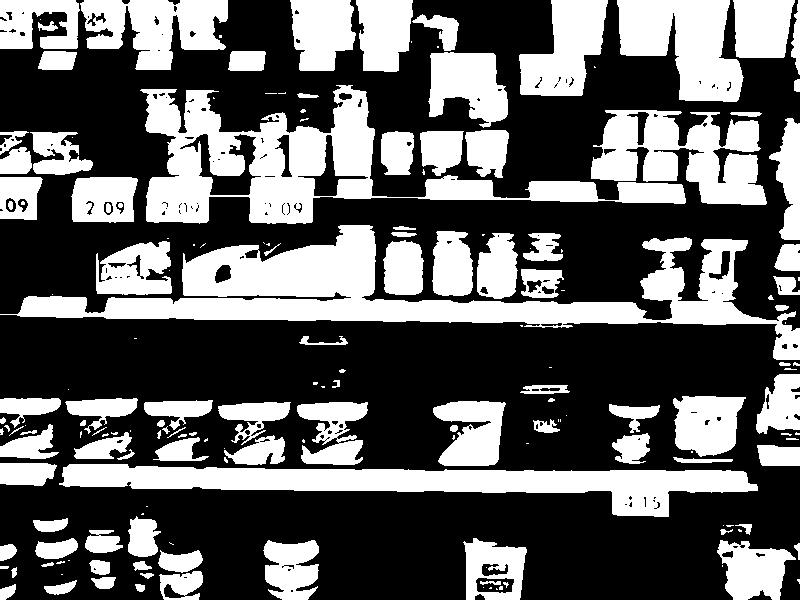

In [12]:
# Single Image Preprocessing
preprocessed_image = preprocess_image_basic(single_image)
cv2_imshow(preprocessed_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

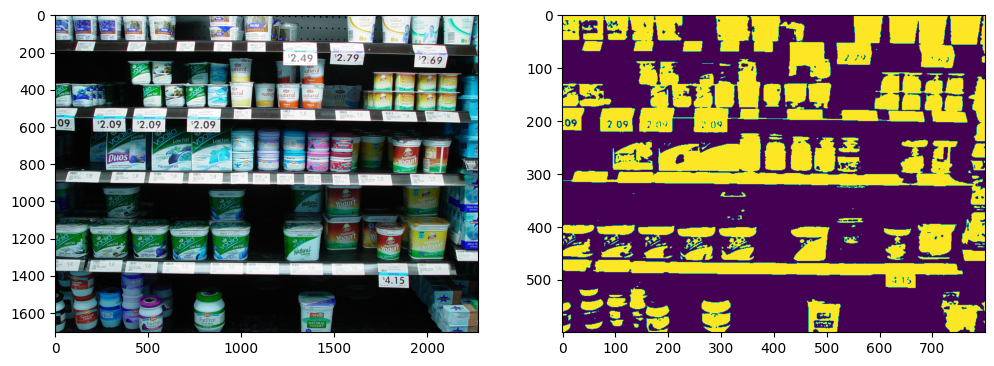

In [13]:
# Single Image Preprocessing

pre_image = preprocess_image(single_image)


## Image Segmention

In [14]:
# This function is to separate foreground vs background in a given image using opencv functionalities, Histogram based thresholding,
# Canny edge detection, followed by Dilation to join the edges followed by creating blobs and reversing the resultant image.

def get_foreground(img):
    '''
    input : img name
    output : Image with Blank space as foreground and rest as background
    '''
    h_kernel = np.ones((5,3),np.uint8)
    kernal = np.ones((3,3),np.uint8)

    #Read the Image in color format
    color=cv2.imread(os.getcwd() + shelves_images_path + img.split(".")[0]+".jpg")
#         color = cv2.resize(color, (780, 540),interpolation = cv2.INTER_NEAREST) 
    gray = cv2.cvtColor(color, cv2.COLOR_BGR2GRAY)
    
    #Threshold the image using Otsu
    ret3,th3 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Create the minimum and maximum threshold values for Canny Edge detection
    hist_eq =cv2.equalizeHist(gray) #equqlising the histogram
    min_thresh=0.66*np.median(hist_eq)
    max_thresh=1.33*np.median(hist_eq)       

    edge_1 = cv2.Canny(gray,min_thresh,max_thresh)
    
    # Dilate the edges to make it more visible
    edge_2 = cv2.dilate(edge_1,None,iterations = 1)
    image_th_inv = cv2.bitwise_not(cv2.dilate(edge_2,h_kernel,iterations = 2))
        
    
    return image_th_inv,gray,ret3

In [15]:
def show_segmentation(img):
    '''
    input: image name
    output : Binarised image with empty space as 1's and products as 0's.
    
    '''
    
    original  = cv2.imread(os.getcwd() + shelves_images_path + img.split(".")[0]+".jpg")    
    image_th_inv,gray,th = get_foreground(img)
#     upp_th = 4/(original.shape[0]*original.shape[0]); count = 1
  
    image_th_inv[image_th_inv > th] = 255
    image_th_inv[image_th_inv < th] = 0   
    _image = cv2.erode(image_th_inv,np.ones((3,3),np.uint8),iterations = 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))#, sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(cv2.cvtColor(original,cv2.COLOR_RGB2BGR))
    ax[1].imshow(_image)
    
    plt.show()
    # cv2.imwrite("CV2_Segmentation/"+img, _image)# cv2.cvtColor(_image,cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.getcwd() + CV2_Segmentation_path +img, _image) 
    return _image

In [16]:
single_image

'db103.jpg'

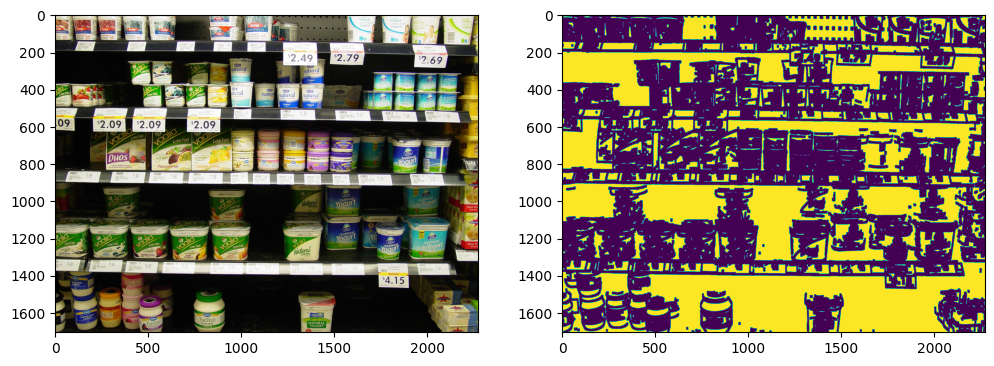

In [17]:
  seg_image = show_segmentation(single_image)

## Image Bounding boxes

In [18]:
# This function combines the identified blobs using DoG (Difference of Gaussian)

def combine_bounding_boxes(upp_th,blob_list_sorted):
    '''
    upp_th  uppr threshold for bbx coordinates difference
    blob_list_sorted : Lsit of blobs whoch needs to be arranged to remove intersecting and overlapping bbx
    
    return : new bounding boxes list
    '''
    for i,val in enumerate(range(0,len(blob_list_sorted))):
        for j in range(i+1,len(blob_list_sorted)-2):
            if max(i,j) < len(blob_list_sorted) and max([abs(np.diff(x)) for x in zip(blob_list_sorted[j][0:2], blob_list_sorted[i][0:2])]) < upp_th:
                blob_list_sorted = blob_list_sorted+[[max(x) for x in zip(blob_list_sorted[j], blob_list_sorted[i])][0:2]+[blob_list_sorted[j][2]+blob_list_sorted[i][2]]]
                del blob_list_sorted[i]
                del blob_list_sorted[j]  
                len_val = len(blob_list_sorted)
    return blob_list_sorted

In [19]:
import warnings
warnings.simplefilter("ignore")

results_cv2 = {"img_name" : [], "bbox" : [], "coords" : []}
filtered = []; contours_list = []; filtered_list = []; contours_ = []; contours_list_updated = []

# Main function #

def main(img):
    '''
    input: image name
    output : Bounding boxes for the empty space where there is no product present
    
    '''    
    
    original  = cv2.imread(os.getcwd() + shelves_images_path + img.split(".")[0]+".jpg")
   
    upp_th = .00392; count = 0
    _image = cv2.imread(os.getcwd() + CV2_Segmentation_path + img.split(".")[0]+".jpg",0)
    
    blobs_dog = blob_dog(_image, max_sigma=40, threshold=.10)    
    blob_list_sorted = sorted([[int(blob[0]), int(blob[1]),int(blob[2])] for blob in blobs_dog])
    blob_list_sorted  = combine_bounding_boxes(upp_th,blob_list_sorted) 

    
    for blob in blob_list_sorted:
        y, x, r = blob
        if 6 < r :   
            original = cv2.rectangle(original,(int(x),int(y)),(int((x+r)),int((y+r))),(255,0,0),2)
            count = count+1
            results_cv2["img_name"].append(str(img.split(".")[0]))
            results_cv2["bbox"].append(count)
            results_cv2["coords"].append([x,y,x+r,y+r])
            
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))#, sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(original)
    
     # getting contours from segmented images
    contours, _ = cv2.findContours(_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    #Looping over all found contours
    objects = np.zeros([original.shape[0],original.shape[1],3], 'uint8')
    for c in contours:        
        #If it has significant area, add to list
        if cv2.contourArea(c) < (_image.shape[0]*_image.shape[1])*.10:#continue
            x = [val[0][0] for val in c]
            y = [val[0][1] for val in c] 
            filtered.append([x,y])
            contours_.append(c)
    
            cv2.drawContours(original,[c], -1, (255,0,0), -1)    
    
    ax[1].imshow(original)

    plt.show()
    cv2.imwrite("Identified_empty_spaces/"+img, original)# cv2.cvtColor(_image,cv2.COLOR_RGB2BGR))        
    return results_cv2,blob_list_sorted,filtered,contours_

In [20]:
image_path[0:10]

['db103.jpg',
 'db1.jpg',
 'db10.jpg',
 'db101.jpg',
 'db100.jpg',
 'db104.jpg',
 'db102.jpg',
 'db111.jpg',
 'db106.jpg',
 'db105.jpg']

In [21]:
## Show Bounding Boxes
for img in image_path[0:4]:
    results_cv2,blob_list_sorted,filtered,contours_ = main(img) 
    filtered_list.append(filtered)
    contours_list_updated.append(contours_)

KeyboardInterrupt: ignored

In [ ]:
'''
input: image name
output : Bounding boxes for the empty space where there is no product present

'''    
img = single_image
original  = cv2.imread(os.getcwd() + shelves_images_path + img.split(".")[0]+".jpg")

upp_th = .00392; count = 0
_image = cv2.imread(os.getcwd() + CV2_Segmentation_path + img.split(".")[0]+".jpg",0)

blobs_dog = blob_dog(_image, max_sigma=40, threshold=.10)    
blob_list_sorted = sorted([[int(blob[0]), int(blob[1]),int(blob[2])] for blob in blobs_dog])
blob_list_sorted  = combine_bounding_boxes(upp_th,blob_list_sorted) 



In [ ]:

for blob in blob_list_sorted:
    y, x, r = blob
    if 6 < r :   
        original = cv2.rectangle(original,(int(x),int(y)),(int((x+r)),int((y+r))),(255,0,0),2)
        count = count+1
        results_cv2["img_name"].append(str(img.split(".")[0]))
        results_cv2["bbox"].append(count)
        results_cv2["coords"].append([x,y,x+r,y+r])
        
fig, axes = plt.subplots(1, 2, figsize=(15, 10))#, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(original)

  # getting contours from segmented images
contours, _ = cv2.findContours(_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

#Looping over all found contours
objects = np.zeros([original.shape[0],original.shape[1],3], 'uint8')
for c in contours:        
    #If it has significant area, add to list
    if cv2.contourArea(c) < (_image.shape[0]*_image.shape[1])*.10:#continue
        x = [val[0][0] for val in c]
        y = [val[0][1] for val in c] 
        filtered.append([x,y])
        contours_.append(c)

        cv2.drawContours(original,[c], -1, (255,0,0), -1)    

ax[1].imshow(original)

plt.show()
cv2.imwrite("Identified_empty_spaces/"+img, original)# cv2.cvtColor(_image,cv2.COLOR_RGB2BGR))   

# Bounding Box

In [22]:
single_image

'db103.jpg'

In [23]:
# Load the CSV file containing bounding box information
csv_file = shelves_coordinates_file
df = pd.read_csv(os.getcwd() + csv_file)

In [25]:
# Filter the DataFrame based on the filename
filtered_df = df[df['filename'] == single_image]
filtered_df

,filename,xmin,ymin,xmax,ymax,class,width,height
6891,db103.jpg,1,375,94,490,object,2272,1704
6892,db103.jpg,1834,317,1942,412,object,2272,1704
6893,db103.jpg,463,375,573,497,object,2272,1704
6894,db103.jpg,820,381,933,499,object,2272,1704
6895,db103.jpg,591,379,698,499,object,2272,1704
...,...,...,...,...,...,...,...,...
6971,db103.jpg,528,261,632,369,object,2272,1704
6972,db103.jpg,1447,1088,1627,1265,object,2272,1704
6973,db103.jpg,409,264,507,372,object,2272,1704
6974,db103.jpg,273,619,487,826,object,2272,1704


In [3]:

# Read the image file
image_path = single_image

# image = cv2.imread(image_path)
image  = cv2.imread(os.getcwd() + shelves_images_path + image_path.split(".")[0]+".jpg")  

# Iterate over each row in the CSV file
for index, row in filtered_df.iterrows():
    
    # Extract bounding box coordinates
    xmin = int(row['xmin'])
    ymin = int(row['ymin'])
    xmax = int(row['xmax'])
    ymax = int(row['ymax'])
    
    # Draw bounding box on the image
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    
# Display the image with bounding box
# cv2.imshow('Image', image)
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

NameError: ignored